# 1. Vector space retrieval

In [1]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
import numpy as np
from operator import itemgetter
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/yawen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yawen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
def cosine_similarity(a,b):
    '''Computes the cosine similarity of $a$ and $b$.'''
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

# # Function to compute cosine similarity
# def cosine_similarity(v1,v2):
#     sumxx, sumxy, sumyy = 0, 0, 0
#     for i in range(len(v1)):
#         x = v1[i]; y = v2[i]
#         sumxx += x*x
#         sumyy += y*y
#         sumxy += x*y
#     if sumxy == 0:
#             result = 0
#     else:
#             result = sumxy/math.sqrt(sumxx*sumyy)
#     return result

### Tokenize + Vocabularize 

- Remove punctuation, stopwords

In [3]:
def tokenize(text):
    stemmer = PorterStemmer()
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens])

In [4]:
def get_original_documents(doc):
    with open(doc + ".txt") as f:
        content = f.readlines()
    original_documents = [x.strip() for x in content]
    return original_documents

def get_documents(doc):
    original_documents = get_original_documents(doc)
    documents = [tokenize(d).split() for d in original_documents]
    return documents

def get_vocabulary(documents):
    # Create vocabulary
    voc = set([item for sublist in documents for item in sublist])
    vocabulary = [word for word in voc if word not in stopwords.words('english')]
    
    return sorted(vocabulary)

### TF-IDF

In [308]:
# tf for 1 document
def get_tf(vocabulary, document):
    tf_dict = dict.fromkeys(vocabulary)
    counts = Counter(document)
    # most common elements for a list
    max_count = counts.most_common(1)[0][1]
    for i,term in enumerate(vocabulary):
        # tf = freq / max-freq
        tf = counts[term] / max_count
        tf_dict[term] = tf
    return tf_dict

In [309]:
# compute IDF, storing idf values in a dictionary
def get_idf(vocabulary, documents):
    idf_dict = {}
    num_documents = len(documents)
    for i, term in enumerate(vocabulary):
        idf_dict[term] = math.log(num_documents/sum(term in document for document in documents), math.e)
    return idf_dict


In [310]:
# Function to generate the vector for a document (with normalisation)
def vectorize(documents, vocabulary):
    document_vectors = []
    idf_dict = get_idf(vocabulary, documents)
    
    for document in documents:
        # vector dimension = len of vocabulary
        vector = [0]*len(vocabulary)
        tf_dict = get_tf(vocabulary, document)
        for i, term in enumerate(vocabulary):
            vector[i] = idf_dict[term] * tf_dict[term]
        document_vectors.append(vector)
    return document_vectors

In [311]:
def vectorize_query(query, documents, vocabulary):
    idf_dict = get_idf(vocabulary, documents)
    
    vector = [0]*len(vocabulary)
    counts = Counter(query)
    max_count = counts.most_common(1)[0][1]
    for i,term in enumerate(vocabulary):
        vector[i] = idf_dict[term] * counts[term]/max_count
    return vector

### Top-k relevant documents query

In [312]:
# Reference code using scikit-learn
# doc: path to doc.txt
# query: ['computer science'] (in list)
def search_vec_sklearn(doc, query, threshold=0.1):
    original_documents = get_original_documents(doc)

    # min_df = When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. 
    tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english')
    # fit_transform: Learn vocabulary and idf, return term-document matrix.
    features = tf.fit_transform(original_documents)
    # npm_tfidf = features.todense()
    # transform: Transform documents to document-term matrix.
    new_features = tf.transform(query) # ['computer science']

    cosine_similarities = linear_kernel(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))    
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold:
            break
        doc_ids.append(related_docs_indices[i])
    return doc_ids


In [313]:
def search_vec(query, documents, document_vectors, vocabulary, topk=5):
    stemmer = PorterStemmer()
    # transform query into document vector
    q = query.split()
    q = [stemmer.stem(w) for w in q] 
    query_vector = vectorize_query(q, documents, vocabulary)
    # Computer similarity
    scores = [[cosine_similarity(query_vector, document_vectors[d]), d] for d in range(len(documents))]
    scores.sort(key=lambda x: -x[0])
    doc_ids = []
    for i in range(topk):
        doc_ids.append(scores[i][1]) 
    return doc_ids

In [316]:
documents = get_documents('notebooks/01.Vector_Space_Retrieval/epfldocs')
vocabulary = get_vocabulary(documents) 
document_vectors = vectorize(documents, vocabulary)
search_vec('computer science', documents, document_vectors, vocabulary)

[4, 838, 795, 30, 89]

In [318]:
relevant_ids = search_vec_sklearn('notebooks/01.Vector_Space_Retrieval/epfldocs', ['computer science'])

### Recall, Accuracy, F1, Interpolated precision, MAP

* MAP(queries = Q) = Mean over all the queries ( mean over all the interpolated precision over 1 query for all k level of recall)

In [319]:
def compute_recall_at_k(predict, gt, k):
    # predict: documents of my own funcs
    # k: int. top k docs recall
    # gt: ground truth
    # We need to use a set cuz there might be recall with slight differences =>
    # we don't care about order of retrieval
    correct_recall = set(predict[:k]).intersection(set(gt))
    return len(correct_recall)/len(gt)

In [320]:
def compute_precision_at_k(predict, gt, k):
    # predict: documents of my own funcs
    # k: int. top k docs precision
    # gt: ground truth
    correct_predict = set(predict[:k]).intersection(set(gt))
    return len(correct_predict)/k

In [321]:
def f1score(predict, gt, k):
    prec = compute_precision_at_k(predict, gt, k)
    rec = compute_recall_at_k(predict, gt, k)
    print(prec, rec)
    return 2*prec*rec/(prec+rec)

# f1score(retrieved_ids_freq, gt_ids, 10)

In [322]:
def compute_interpolated_precisions(prec_rec):
    max_prec = []
    current_rec = prec_rec[-1][1]  # lastest (precision, recall)
    for k, (prec, rec) in enumerate(prec_rec):
        max_precision = prec
        # get max precision from position k & on => precision can only
        # decrease monotonically
        for j, (precision, recall) in enumerate(prec_rec[k+1:]):
            if precision > max_precision and recall >= rec:
                max_precision = precision
        max_prec.append(max_precision)
    return max_prec

In [323]:
def compute_map(queries):
    documents = get_documents('notebooks/01.Vector_Space_Retrieval/epfldocs')
    vocabulary = get_vocabulary(documents) 
    document_vectors = vectorize(documents, vocabulary)

    map_score = 0
    prec_rec_dict = []
    for i, query in enumerate(queries):
        predict = search_vec(query, documents, document_vectors, vocabulary, 10)
        gt = search_vec_sklearn('notebooks/01.Vector_Space_Retrieval/epfldocs', [query]) # relevant doc ids
        prec_rec = []
        
        for k in range(1, len(gt)+1):
            precision_at_k = compute_precision_at_k(predict, gt, k)
            recall_at_k = compute_recall_at_k(predict, gt, k)
            prec_rec.append((precision_at_k, recall_at_k))
        
        # get a list of monotonically decreasing precisions
        precs_int = compute_interpolated_precisions(prec_rec) 
        map_score += sum(precs_int)/len(gt)
        prec_rec_dict.append(prec_rec)
    # mean average precision over all the queries for all level of 
    # recall
    map_score = map_score/len(queries)
    return map_score, prec_rec_dict

In [324]:
queries = ["computer science", "IC school", "information systems"]
map_score, prec_rec_dict = compute_map(queries) # MAP over 3 queries

# 2. Probabilisitic Retrieval and Inverted Files

### Construct inverted files with MapReduce

In [325]:
# Take a pair (doc_id, content). Example: (0, ['how', 'to', 'bake', 'bread', 'without', 'bake', 'recip'])
# Return: list of (word, doc_id). Example: ('bake', 0)
# For simplicity, we assume each mapper handles a document
def map_function(doc_id, content):
    keyvals = []
    for word in content:
        keyvals.append((word, doc_id))
    return keyvals

In [326]:
# Take a list of pairs (word, doc_id). Example:  [('bake', 0), ('bake', 0), ('bake', 3)]
# Return: (word, frequency, list of document ids). Example ('bake', 3, [0, 0, 3])
# For simplicity, we assume each reducer handles a word
def reduce_function(lst):
    total = 0
    # [(**'food'**, 158), ('food', 323), ...]
    word = lst[0][0] # the word this reducer handles
    doc_ids = []
    for w, doc_id in lst:
        assert(word==w) # Assume each reducer handles 1 word
        total = total + 1 
        doc_ids.append(doc_id)
    return (word, total, doc_ids)

In [327]:
# We simulate the mapreduce framework by this function
def run_mapreduce(docs_n_doc_ids):
    # Map phase
    key_values = [] # (word, docid)
    for doc_id, doc_content in docs_n_doc_ids:
        key_values.extend(map_function(doc_id, doc_content))
    # Shuffle phase
    values = set(map(lambda x:x[0], key_values)) # list of words
    # ordered list of [('thesi', 401), ('thesi', 469), ('thesi', 502), ...]
    grouped_key_values = [[y for y in key_values if y[0]==x] for x in values] 
    # Reduce phase
    inverted_files = []
    for grouped_key_value in grouped_key_values:
        word, total, doc_ids = reduce_function(grouped_key_value)
        inverted_files.append((word, total, doc_ids)) # wordkey, #docs, docids (postings)
    return inverted_files

In [328]:
documents = get_documents('notebooks/01.Vector_Space_Retrieval/epfldocs')
# zip('ABCD', 'xy') --> Ax By. Zip 1st must be iteration
docs_n_doc_ids = list(zip(range(len(documents)), documents))
inverted_files = run_mapreduce(docs_n_doc_ids)
inverted_files[0]

('know', 4, [102, 215, 353, 778])

### Distributed Info Retrieval - Fagin's Algorithm for topk docs

In [330]:
path = "notebooks/01.Vector_Space_Retrieval/bread"
original_documents = get_original_documents(path)
documents = get_documents(path)

vocabulary = get_vocabulary(documents) 
document_vectors = vectorize(documents, vocabulary)
doc_vecs = np.transpose(np.array(document_vectors))

# Construct posting lists
h = {} # decreasing sorted tf-idf per term for all documents
# {'art': [(2, 1.6094379124341003), (0, 0.0), (1, 0.0), (3, 0.0), (4, 0.0)],
for i, term in enumerate(vocabulary):
    ha = {}
    for docj in range(len(original_documents)):
        tfidf = doc_vecs[i][docj]
        ha[docj] = tfidf
    # tf-idf for 1 term for every documents
    sorted_ha = sorted(ha.items(), key=itemgetter(1), reverse=True) 
    h[term] = sorted_ha
    
    

In [331]:
def fagin_algorithm(query, h, k, vocabulary):
    
    # Split and stem the query
    q = query.split()
    q = set([stemmer.stem(w) for w in q])
    query_term_cnt = len(q)
#     print(q)
    
    # select the posting lists for the query terms
    posting_lists = {}
    for term in q:
        if term in h:
            posting_lists[term] = h[term] # h['bread'] + h['recip']

    max_len = len(documents)
    
    # Traverse the selected posting lists until we found k documents that appear in ALL posting lists
    # This corresponds to phase 1 of Fagin's algorithm.
    # As a result you produce a dictionary documents_occurrences, with the document identifiers as keys, 
    # and the number of documents found as value.
    # We stop traversing the posting lists until we have found k documents that appear in ALL posting lists 
    # of the query terms

    documents_occurrences = {}
    l = 0
    found_documents = 0
    while l < max_len:
        for term in q:
            d  = posting_lists[term][l][0] # document id: (**2**, 1.6094379124341003)
            if d in documents_occurrences.keys():
                documents_occurrences[d] = documents_occurrences[d]+1
            else:
                documents_occurrences[d] = 1
                
            if documents_occurrences[d] == query_term_cnt:
                found_documents = found_documents + 1
        if found_documents == k:
            l = max_len + 1 # get out of the loop
            break
        else:
            l = l+1
                
    print("documents_occurrences: ", documents_occurrences)
        
    # Retrieve for the found documents the tfidf values and add them up.
    # For simplicity, we do not distinguish the cases whether the values have already been retrieved in the 
    # previous phase, or whether we use random access to obtain those values
    
    tfidf = {}
    for d in documents_occurrences.keys():
        t = 0
        for term in q:
            t = t + dict(posting_lists[term])[d]
        tfidf[d] = t
        
    # Finally we compute the top-k documents and return the answer
    
    ans = sorted(tfidf.items(), key=lambda x:x[1], reverse = True)[:k]
    return ans

# h = dictionary of decreasing sorted tf-idf per term for all documents
# {'art': [(2, 1.6094379124341003), (0, 0.0), (1, 0.0), (3, 0.0), (4, 0.0)],
ans = fagin_algorithm("bread recipe", h, 2, vocabulary)
print(ans)
for document_id in ans:
    print(original_documents[document_id[0]])

documents_occurrences:  {0: 2, 1: 1, 2: 1, 3: 2}
[(3, 1.1394342831883648), (0, 0.5697171415941824)]
Breads, Pastries, Pies, and Cakes: Quantity Baking Recipes
How to Bake Breads Without Baking Recipes


# 3. Latent Semantic Indexing & Word Embedding

### 3.1 Latent Semantic Indexing

#### M_s = K_s * S_s * D_s.T

- M = m terms x n documents - term-doc matrix
- M_s: only the S largest singular values 
- K_s: m terms x s importances
- S_s = s * s sorted singular values
- D_s.T = s * n documents

#### How to answer queries:

* Use cosine similarity to compaire documents: (Ds.T)i (ith column), (Ds.T)j (jth column)
* Query = additional document
* Mapping M ==> D:  D = M.T * K * S^-1
* **Mapping query** : q* = q.T * K.s * S.s^-1
* **Comparing similarities**: sim(q*, d_i) = (q* dot (Ds.T)i) / (norm(q*) * norm(Ds.T_i))

#### Dropping a document d3 in document space...
The document ordering does not change even if d3 is dropped. Recall that all the documents in the term-document matrix can be considered as vectors in a  Rm dimensional vector space. Thus, since d3 has a similar magnitude and direction as d4 and d2, dropping d3 does not alter substantially the term space ( K ) and the document space ( D ) of the SVD.

To modify the term and document space we should change d3 such that it in a different direction as compared to the other vectors. For example, d3 = (0, 0, 1, 1, 2, 1, 0, 0, 2, 0, 2) changes the document ordering to d2 > d4 > d1 > d3.


In [211]:
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords

In [222]:
def SVD(M):
    # compute SVD
    K, S, Dt = np.linalg.svd(M, full_matrices=False) # K = min(M, N) if full_matrices = False
    return K, S, Dt

K, S, Dt =  SVD(M)

def SVD_k(M, k):
    K, S, Dt = SVD(M)
    # LSI select dimensions
    K_sel = K[:,0:k]
    S_sel = np.diag(S)[0:k,0:k]
    Dt_sel = Dt[0:k,:]
    return K_sel, S_sel, Dt_sel

In [246]:
# q = quest; M = Term-doc matrix; k = top k documents;
def q_star(q, M, k):
    K, S, Dt = SVD(M)
    
    K_sel = K_sel = K[:,0:k]
    S_sel = np.diag(S)[0:k,0:k]
    #Map the query q onto the document space D as q* = qT · (K_sel · S_sel−1)
    mapper = np.dot(K_sel, np.linalg.inv(S_sel))
    q_trans =  np.dot( q, mapper)
    return q_trans

def rank_documents(q_star, Dt, k):
    # dict of (doc_id, cos_sim)
    document_ranking = dict()
    # Shrink the documents according to highest k singular values
    Dt_sel = Dt[0:k,:]

    for i in range(0, Dt_sel.shape[1]):
        d = Dt_sel[:, i]
        cos_sim = cosine_similarity(q_star, d)
        document_ranking[i] = cos_sim
    
    # Sort according to values
    document_ranking_sorted = sorted(document_ranking.items(), key=itemgetter(1), reverse = True)
    return document_ranking_sorted


In [237]:
#### Find top documents for quest 'baking', with k = 3 ####
documents = get_documents('notebooks/01.Vector_Space_Retrieval/bread')
vocabulary = get_vocabulary(documents) 
document_vectors = vectorize(documents, vocabulary)

## take transpose of document vectors to convert to term document matrix.
M = np.matrix.transpose(np.array(document_vectors))

## Run LSI.
K, S, Dt = SVD(M)
K_sel, S_sel, Dt_sel = SVD_k(M, 3)

## Prepare query
# transform query and documents
q = np.array([0]*len(vocabulary))
#Set the term corresponding to baking = 1 (see vocabulary)
q[1] = 1
q__ = q_star(q, M, 3) # query in concept space

# Compute similarities
rank_documents(q__, Dt, 3)

[(0, 0.9980518678772611),
 (3, 0.7231078789682566),
 (2, -0.002328875052966951),
 (4, -0.6551062911362043),
 (1, -0.6577609566355738)]

#### 3.1.2 Midterm

In [247]:
def read_corpus():
    '''Reads corpus from files.'''
    stop_words = set(stopwords.words('english')).union(set(stopwords.words('french')))
    documents = []
    orig_docs = []
    DIR = './'
    tknzr = TweetTokenizer()
    with open("notebooks/01.Vector_Space_Retrieval/epfldocs.txt", encoding = "utf-8") as f:
        content = f.readlines()
    for text in content:
        orig_docs.append(text)
        # split into words
        tokens = tknzr.tokenize(text)
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        # filter out stop words
        words = [w for w in words if not w in stop_words]

        documents.append(' '.join(words))
    return documents, orig_docs

def construct_term_document_matrix(vocabulary, documents):
    # Construct term-doc matrix
    matrix = np.zeros((len(vocabulary), len(documents)))
    for j, document in enumerate(documents):
        counter = Counter(document.split())
        for i, word in enumerate(vocabulary):
            if word in counter:
                # i'th word, j'th doc => # occurence
                matrix[i,j] = counter[word] 
    return matrix

# same as SVD_k
def truncated_svd(term_doc_matrix, num_val):
    K, S, Dt = np.linalg.svd(term_doc_matrix, full_matrices=False)
    K_sel = K[:,0:num_val]
    S_sel = np.diag(S)[0:num_val,0:num_val]
    Dt_sel = Dt[0:num_val,:]
    return K_sel, S_sel, Dt_sel


In [251]:
# Construct query vector => treat as a new document vector
def query_to_document_vector(query, vocabulary):
    vector = np.zeros(len(vocabulary))
    for word in query:
        try:
            vector[vocabulary.index(word)] += 1
        except: # if query word is not in vocabulary
            # ignore it => cuz initial vector = 0 vector
            pass
    return vector

# q_star = q.T * K_k * S_k^-1
def construct_query_vector(query, vocabulary, K_sel, S_sel):
    q = query_to_document_vector(query, vocabulary)
    mapper = np.dot(K_sel, np.linalg.inv(S_sel))
    q_trans =  np.dot( q, mapper)
    return q_trans

def retrieve_documents(query_vector, top_k, Dt_sel):
    # Compute similarity of q_star with all docs in concept space
    # Take top k
    scores = [[cosine_similarity(query_vector, Dt_sel[:,d]), d] for d in range(len(documents))]
    scores.sort(key=lambda x: -x[0])
    doc_ids = []
    retrieved = []
    for i in range(top_k):
        doc_ids.append(scores[i][1])
        retrieved.append(orig_docs[scores[i][1]])
    return doc_ids, retrieved

In [242]:
documents, orig_docs = read_corpus()
vocab_freq = create_vocabulary_frequency(documents, 1000)
term_doc_matrix_freq = construct_term_document_matrix(vocab_freq, documents)
K_freq, S_freq, Dt_freq = truncated_svd(term_doc_matrix_freq,100)

query = ['epfl']
query_vector_freq = construct_query_vector(query, vocab_freq, K_freq, S_freq)
retrieved_ids_freq, retrieved_docs_freq = retrieve_documents(query_vector_freq, 10, Dt_freq)


/anaconda3/envs/dis2019/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


### 3.2 Word Embeddings
- Local proximity: S words before & after the word

In [341]:
import sys
import codecs
import numpy as np

# Edit this, or just move model_epfldocs.vec to the directory where this notebook is situated
directory_path = 'notebooks/03.Advanced_Information_Retrieval/'
original_documents = get_original_documents(directory_path + 'epfldocs')

def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary

# Replace the path based on your own machine.
word_embeddings, vocabulary = load_embeddings(directory_path + 'model_epfldocs.vec')


* Find the most similar term to a query term in the vocabulary using word embeddings.

In [340]:
# Find the most similar term to a query term in the vocabulary using word embeddings.
def find_most_similar(input_term, word_embeddings, vocabulary, num_terms=3):
    # For later easier computation.
    term_embedding_dict = {}
    for i, term in enumerate(vocabulary):
        term_embedding_dict[term] = word_embeddings[i]
    
    if input_term not in term_embedding_dict:
        return "Not in embedding"
    
    input_term_embedding = term_embedding_dict[input_term]
    
    # Compute cosine similarity of each term in voc with the search term
    term_similarities = {}
    for term, word_embedding in term_embedding_dict.items():
        term_similarities[term] = cosine_similarity(input_term_embedding, word_embedding)
    
    # Sort similarity of the terms in reverse order according to similarities
    sorted_similarities = sorted(term_similarities.items(), key=itemgetter(1), reverse=True)
    
    return sorted_similarities[0: num_terms]

find_most_similar('EPFL', word_embeddings, vocabulary, num_terms=5)


[('EPFL', 1.0),
 ('@EPFL', 0.9998978811406759),
 ('#EPFL', 0.9998585853994781),
 ('l’#EPFL', 0.9997859775153901),
 ('@EPFLevents', 0.9997827153523552)]

#### Querying using Word Embedding
Find the n most similar documents to a multiple-word query using word-embedding.
1. Aggregate all the word embedding vectors in each document using max/min/mean all word vectors in 1 document.
2. Put the query vector to word embedding vector in the same way
3. Using sklearn cosine_similarity, calculate the cosine_sim in one shot of all documents vs query vector, then take the top n similar.

In [334]:
# Since both document & query is variable size
# Aggregate the vectors of the words in the query by taking
# min vector / max vector / mean
def aggregate_vector_list(vlist, aggfunc):
    if aggfunc == 'max':
        return np.array(vlist).max(axis=0)
    elif aggfunc == 'min':
        return np.array(vlist).min(axis=0)
    elif aggfunc == 'mean':
        return np.array(vlist).mean(axis=0)
    else:
        return np.zeros(np.array(vlist).shape[1])

possible_aggfuncs = ["max", "min", "mean"]

In [336]:
# Create a dictionary of vectors for easier search
vocabulary_embedding_dict = dict(zip(vocabulary, word_embeddings))

# Aggregate vectors of documents beforehand => each document has multiple words
# Need an aggregated representation to represent all the word embeddings vectors for 1 documents
# Thus we can take the mean/max/min of all the word embeddings vectors
# Be sure to tokenize the document with nltk.word_tokenize!
aggregated_doc_vectors = {}
# For max, min, mean
for aggfunc in possible_aggfuncs:
    # Initialize with zero vector
    aggregated_doc_vectors[aggfunc] = np.zeros((len(original_documents), word_embeddings.shape[1]))
    
    # For each document
    for index, doc in enumerate(original_documents):
       # Vlist represent all the word embedding vectors for each word in a document 
        vlist = []
        for token in nltk.word_tokenize(doc):
            if token in vector_dict:
                vlist.append(vector_dict[token])
                
        if(len(vlist) < 1): # if the document has no word recognized in the vocabulary
            print(index)
            continue
        else:
            aggregated_doc_vectors[aggfunc][index] = aggregate_vector_list(vlist, aggfunc) 
            
        # aggregated_doc_vectors['max'] has 1 vector of dimension 100 per document!
        

In [353]:
query = "EPFL"

def aggregate_query(query, aggfunc):
    # Raise an error message for the case when there is no words in the query that is included in the vocabulary
    # This should return a vector of shape (1, word_embeddings.shape[1])
    vlist = []
    words = nltk.word_tokenize(query)
    query_word_not_in  = 0
    for word in words:
        if word not in vector_dict:
            query_word_not_in += 1
        else:
            vlist.append(vector_dict[word])
    
    if query_word_not_in == len(words):
        raise("No word in query is in dictionary")
    
    return vlist
            
from sklearn.metrics.pairwise import cosine_similarity

def get_most_similar_documents(query_vector, aggfunc, k = 5):
    # Calculate the similarity with each document vector. 
    # Hint: Cosine similarity function takes a matrix as input so you do not need to loop through each document vector.
    sim = cosine_similarity(query_vector, aggregated_doc_vectors[aggfunc])
    
    # Rank the document vectors according to their cosine similarity with 
    indexes = np.argsort(sim, axis=-1, kind='quicksort', order=None)
    indexes = indexes[0] # because it's a [[array]]
    return indexes


def search_vec_embeddings(query, topk = 10, aggfunc = 'mean'):
    query_vector = aggregate_query(query, aggfunc)
    indexes = get_most_similar_documents(query_vector, aggfunc)
    # Print the top k documents
    indexes = indexes[0:topk]
    print(indexes)
    for index in indexes:
        print(original_documents[index])
        
search_vec_embeddings('EPFL', aggfunc = 'mean')


[ 981   90  674  207   94  584  706   47 1051  325]
@EPFL go to https://t.co/go0ZwhqT8d … … … … … … … … and read my campaign for the 2020 election
After jet lag, before forgetting: HK–CHIC, episode 6 @chic_community #epfl #voyage #hongkong https://t.co/3LNG5suuw8 …
"1946: No longer scared of the dark" His #CV is a gem https://t.co/H1TCmSsNJB … @unil @epfl @UNIGEnews @embl #Nobel https://t.co/YaFnD9cIOr
Pause déjeuner , moment de convivialité en plein coeur de #Portivechju avant de reprendre les travaux de l'AG de #Association des #EPFL https://t.co/NZhkFZTpxe
Et des super-pouvoirs des bibliothécaires de la BCU alors ? https://t.co/jOYiUOrOHe
Bras de fer autour de la taxe d’études de l'#EPFL https://t.co/pr7GBU3f04
Deux mois à Pyeongchang pour étudier la neige coréenne https://t.co/UWFtrbqvyH #epfl
L'EPFL sera la capitale des drones début septembre https://t.co/QdxCmZa3bV #epfl
Des ordinateurs prêts à faire de l'ombre à #Bach ou #Beethoven #EPFL https://t.co/udQn1RpSpf
Il ne vous reste 

# 4. Relevance Feedback

### 4.1 Rocchio: Query modification to retrieve more relevant documents

Rocchio's method for user relevance feedback - Try to modify the query vector so that it falls more in the relevant documents section.

Belong s SMART Rocchio with alpha + beta + gamma for tuning.

In the Rocchio algorithm negative term weights are ignored. This means, for the negative term weights in $\vec{q_m}$, we set them to be 0.

$D_r $ : Set of relevant documents

$D_{nr}$: Set of unrelevant documents

$\vec{q_m}$ : Modified query

\begin{equation}
\vec{q_m} = \alpha \vec{q_0} + \frac{\beta}{|D_r|} \sum_{\vec{d_j} \in D_r} \vec{d_j} - \frac{\gamma}{|D_{nr}|} \sum_{\vec{d_j} \in D_{nr}} \vec{d_j}
\end{equation}

* Query expansion also possible with Thesaurus + User Query Logs 

In [5]:
def expand_query(relevant_doc_vecs, non_relevant_doc_vecs, query_vector, alpha, beta, gamma):
    
    num_rel = len(relevant_doc_vecs)
    num_non_rel = len(non_relevant_doc_vecs)
    
    # Compute the first term in the Rocchio equation
    norm_query_vector = alpha * query_vector
    
    # Compute the second term in the Rocchio equation
    norm_sum_relevant = (beta / num_rel) * np.sum(relevant_doc_vecs, axis=0) 
    
    # Compute the last term in the Rocchio equation
    norm_sum_non_relevant = (gamma / num_non_rel) * np.sum(non_relevant_doc_vecs, axis=0)
    
    # Sum all the terms
    modified_query_vector = norm_query_vector + norm_sum_relevant - norm_sum_non_relevant
    
    # Ignore negative elements (so that it doesn't)
    modified_query_vector = [x if x > 0 else 0 for x in modified_query_vector]
    return modified_query_vector

### 4.2 Page Rank: Link based ranking

#### 4.2.1 Page Rank EigenVector method

1. Link Matrix L : (i, j) no links from i to j
2. R Matrix: Normlized L
3. p = page ranks vectors => Eigenvector of the largest eigenvalue of R

In [6]:
# L = link matrix, np.matrix
def pagerank_eigen(L):
#   Construct transition probability matrix from L
    # R is the normalised matrix of L
    col_sums = L.sum(axis=0)
    # To avoid division by 0
    col_sums[col_sums == 0] = 1
    R = L / col_sums
#     R = np.multiply(L, 1 / np.sum(L,axis=0))
    
#     Compute eigen-vectors and eigen-values of R
    eigenvalues, eigenvectors = np.linalg.eig(R)
#     Take the eigen-vector with maximum eigven-value
    p = eigenvectors[:,np.argmax(np.absolute(eigenvalues))]
    return (R,p)

In [7]:
L = np.matrix([
    [0,1,1], # row1: links pointing to p1
    [1,0,1], 
    [1,0,0]
])  # col1 : links p1 points to (different than HITS!!)

R,p = pagerank_eigen(L)
print("L={0}\nR={1}\np={2}".format(L,R,p))

L=[[0 1 1]
 [1 0 1]
 [1 0 0]]
R=[[0.  1.  0.5]
 [0.5 0.  0.5]
 [0.5 0.  0. ]]
p=[[-0.74278135+0.j]
 [-0.55708601+0.j]
 [-0.37139068+0.j]]


#### 4.2.2 Page Rank Iterative method

The eigen-vector method has some numerical issues (when computing eigen-vector) and not scalable with large datasets.


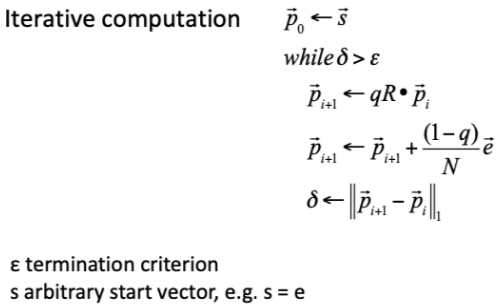

In [400]:
# L = Link matrix. np.matrix
def pagerank_iterative(L):
    R = np.multiply(L, 1 / np.sum(L,axis=0))
    N = L.shape[0]
    e = np.ones(shape=(N,1))
    q = 0.9

    p = e
    delta = 1
    epsilon = 0.001
    i = 0
    while delta > epsilon:
        p_prev = p
        p = np.matmul(q * R, p_prev)
        p = p + ((1-q)/N) * e
        delta = np.linalg.norm(p - p_prev, 1)
        i += 1

    print("Converged after {0} iterations. Ranking vector: p={1}".format(i, p[:,0]))
    return R,p

In [408]:
R, p = pagerank_iterative(L)

Converged after 52 iterations. Ranking vector: p=[[0.44049233]
 [0.33611637]
 [0.23174042]]


### 4.3 HITS - Hubs & Authorities : Link based ranking

Hyperlink-induced topic search

**Authority pages**: Pages the hubs pages point to. Ex. EPFL - **a** = authority vector

**Hub pages**: Pages that points to authority pages Ex. QSRanking - **h** = hub vector

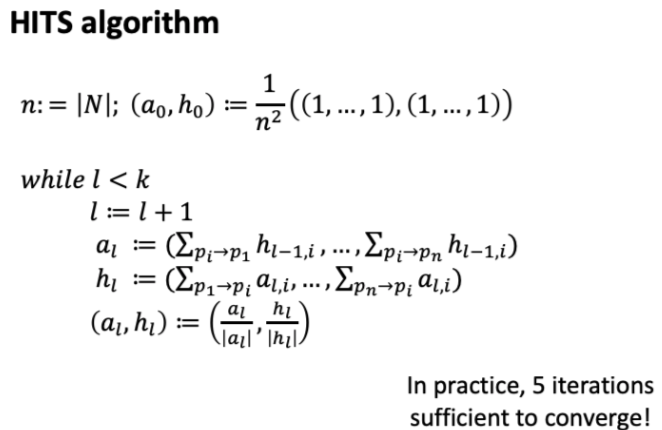

In [8]:
# A = adjacency matrix => need to be an np.array, not matrix!!
def hits_iterative(A, k = 10):
    N = A.shape[0]
    a0, h0 = 1 / (N*N) * np.ones(N), 1 / (N*N) * np.ones(N) 
    aprev, hprev = a0, h0
    delta1 = delta2 = 1
    epsilon = 0.001 # We can strictly check for convergence rate of HITS algorithm
    l = 0
    while l < k and delta1 > epsilon and delta2 > epsilon:
        h = np.matmul(A, aprev) # hub: how many authority i point to?
        a = np.matmul(np.transpose(A), h) # authority: how many hubs points to me?
        
        a = a / np.linalg.norm(a,2)
        h = h / np.linalg.norm(h,2)
        
        delta1 = np.linalg.norm(a-aprev,1)
        delta2 = np.linalg.norm(h-hprev,1)
        aprev = a
        hprev = h
        l += 1
    
    print("Ran a total of {0} iterations with the convergence rate delta1, delta2={1},{2}".format(l, delta1, delta2))
    return aprev, hprev

A=np.array([
    [0, 1, 1, 1], # row1: nb links node 1 points to
    [0, 0, 1, 1], 
    [1, 0, 0, 1],
    [0, 0, 0, 1],
])  #col1 : nb links pointing to node 1 (different than PageRank's Link matrix!!)

a, h = hits_iterative(A, 100)
print("Result using iterative method:\n Authoriy vector x={0}\n Hub vector y={1}".format(a, h))

Ran a total of 4 iterations with the convergence rate delta1, delta2=0.0006129616443491803,0.0016852780559584724
Result using iterative method:
 Authoriy vector x=[0.16854345 0.27253834 0.49794598 0.80583234]
 Hub vector y=[0.65541849 0.54207544 0.40532459 0.33510118]


**HITS recursive:**  

S : authorities, T: Hubs

$\vec{t}_{k+1} = r_1  M_1. \vec{v_1},\ \vec{s}_{k+1} = r_2  M_2 . \vec{v_2}$

$\vec{t}=(t_1,\ldots,t_n)$ and $\vec{s}=(s_1,\ldots,s_m)$ are the vectors ranking interest and expertise of users and universities. Your task is to express $r_p$, $\vec{v_p}$ and $M_p$, $p=1,\ldots,5$ in terms of $\vec{t}_{k}$, $\vec{s}_{k}$ and $F$, where $r_p$ are scalars, $\vec{v_p}$ are vectors and $M_p$ are matrices.

* For hubs t2: r1 = 1/ norm of s1, M1 = Adjency matrix, v1 = previous authority vector (s1)
* For authorities s2: r2 = 1 / norm of t2, v2 = t2, M2 = transpose of Adjacency matrix 

In [19]:
def hits_recursive(A, k = 10):
    N = A.shape[0]
    delta1 = delta2 = 1
    epsilon = 0.001 # We can strictly check for convergence rate of HITS algorithm
    
    if k == 1:
        a0, h1 = 1 / (N*N) * np.ones(N), 1 / (N*N) * np.ones(N) 
        a1 = np.matmul(np.transpose(A), h1)
        
        a1 = a1 / np.linalg.norm(a1,2)
        h1 = h1 / np.linalg.norm(h1,2)
        
#         print("a1: {}, h1:{}".format(a1, h1))
        
        return a1, h1
    
    else:
        aprev, _ = hits_recursive(A, k-1)
        
        h = np.matmul(A, aprev) # hub: how many authority i point to?
        a = np.matmul(np.transpose(A), h) # authority: how many hubs points to me?
        
        a = a / np.linalg.norm(a,2)
        h = h / np.linalg.norm(h,2)
        
#         print("k: {}, a: {}, h: {}".format(k, a, h))
        
        return a, h

In [35]:
a, h = hits_recursive(A, 8)
print("Result using recursive method:\n Authoriy vector x={0}\n Hub vector y={1}".format(a, h))

Result using recursive method:
 Authoriy vector x=[0.59133282 0.73683204 0.32772556]
 Hub vector y=[0.59054099 0.32836047 0.73718433]


In [32]:
# To resuse link matrix from Page rank:
A = np.array(np.transpose(L))
a, h = hits_iterative(A, 100)
print("Result using iterative method:\n Authoriy vector x={0}\n Hub vector y={1}".format(a, h))

Ran a total of 8 iterations with the convergence rate delta1, delta2=0.0005478431302090025,0.0007919169475945065
Result using iterative method:
 Authoriy vector x=[0.59078493 0.73707593 0.32816497]
 Hub vector y=[0.59133282 0.32772556 0.73683204]


Let the adjacency matrix for a graph of four vertices ($n_1$ to $n_4$) be
as follows:

$
A =
  \begin{bmatrix}
	0 & 1 & 1 & 1  \\
	0 & 0 & 1 & 1 \\
	1 & 0 & 0 & 1 \\
	0 & 0 & 0 & 1 \\
  \end{bmatrix}
$

**Details:**
**Notice that for authority: A.T, for hubs: A !**
+ Initialization: 
  
  $a_0 = \frac{1}{4^2}(1,1,1,1) = ( 0.0625,  0.0625,  0.0625,  0.0625)$
  
  $h_0 = \frac{1}{4^2}(1,1,1,1) = ( 0.0625,  0.0625,  0.0625,  0.0625)$
  
+ $k=1$:
  
  $a_1 = \frac{A^t h_0}{||A^t h_0||} = (0.21320072,  0.21320072,  0.42640143,  0.85280287)$
  
  $h_1 = \frac{A a_0}{|| A a_0 ||} = (0.70710678,  0.47140452,  0.47140452,  0.23570226)$
  
+ ...:
  
+ $k=6$:
  
   $a_6 = \frac{A^t h_5}{||A^t h_5||} = (0.16887796,  0.27257494,  0.49774555, 0.80587375)$
  
  $h_6 = \frac{A a_5}{||A a_5||} = (0.65357971,  0.54153747,  0.40815386,  0.33612671)$
  

**Conclusion:**
+ Best authority node: $n_4$. Best hub node: $n_1$.